In [4]:
#Load packages
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from os import path
import community
import itertools
from random import choice
import plotly.express as px
from collections import Counter
import pandas as pd
import re
import warnings
from plotly.subplots import make_subplots
import nltk
import pickle
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import WordPunctTokenizer 
from nltk.stem import WordNetLemmatizer
import json
import community as community_louvain
import community as generate_dendrogram
import numpy as np
import matplotlib.pyplot as plt
from fa2 import ForceAtlas2
from nltk.probability import FreqDist
import math
from nltk.tokenize import sent_tokenize
from nltk.corpus import PlaintextCorpusReader
from fa2 import ForceAtlas2
from pyvis import network as net
from pyvis.network import Network
from IPython.core.display import display, HTML
import seaborn as sns
import vaderSentiment
from sklearn.feature_extraction.text import CountVectorizer
import pylab 
from random import randint
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import IFrame

In [2]:
import plotly.offline as py
import plotly.graph_objs as go

In [3]:
import plotly.io as pio
pio.renderers.default = "colab"

In [5]:
import plotly
plotly.offline.init_notebook_mode(connected=False)
plotly.offline.plot

<function plotly.offline.offline.plot(figure_or_data, show_link=False, link_text='Export to plot.ly', validate=True, output_type='file', include_plotlyjs=True, filename='temp-plot.html', auto_open=True, image=None, image_filename='plot_image', image_width=800, image_height=600, config=None, include_mathjax=False, auto_play=True, animation_opts=None)>

## Tools, theory and analysis  <a name="theory"></a>


In this section several network science tools and data analysis strategies has been applied in order to meet the objective of the project. 

### Define networks <a name="Network_def"></a>

First step is to load the data that we have scraped and preprocessed from the data preprocessing notebook. 

In [6]:
# Load Graph to perform exploratory analysis
file_to_read_movies = open("./data_to_analysis/graph_G.pickle", "rb")
G = pickle.load(file_to_read_movies)
file_to_read_movies.close()

# Load preprocesses dataframe
file_to_read_characters = open("./data_to_analysis/df_characters.pickle", "rb")
df_characters = pickle.load(file_to_read_characters) 
file_to_read_characters.close()

# load the movie dataframe from the data preprocessing
file_to_read_movies = open("./data_to_analysis/df_movies.pickle", "rb")
df_movies = pickle.load(file_to_read_movies)
file_to_read_movies.close()

#load the tv dataframe from the web scrbing preprocessing
file_to_read_movies = open("./data_to_analysis/df_tv.pickle", "rb")
df_tv = pickle.load(file_to_read_movies)
file_to_read_movies.close()

# Load links from data scraping
file_to_read_movies = open("./data_to_analysis/links.pickle", "rb")
links = pickle.load(file_to_read_movies)
file_to_read_movies.close()

# Load number of links from data scraping
file_to_read_movies = open("./data_to_analysis/links_no.pickle", "rb")
links_no = pickle.load(file_to_read_movies)
file_to_read_movies.close()



In [7]:
# load graph attributes from webscrabing
file_to_read_movies = open("./data_to_analysis/attributes.pickle", "rb")
attributes = pickle.load(file_to_read_movies)
file_to_read_movies.close()

file_to_read_movies = open("./data_to_analysis/attributes_org_character.pickle", "rb")
attributes_org = pickle.load(file_to_read_movies)
file_to_read_movies.close()

file_to_read_movies = open("./data_to_analysis/attributes_character_team.pickle", "rb")
attributes_teams = pickle.load(file_to_read_movies)
file_to_read_movies.close()


# Organisation graph
file_to_read = open("./data_to_analysis/org_shared.pickle", "rb")
org_shared = pickle.load(file_to_read)
file_to_read.close()

file_to_read = open("./data_to_analysis/org_characters.pickle", "rb")
org_characters = pickle.load(file_to_read)
file_to_read.close()

file_to_read = open("./data_to_analysis/links_no_org.pickle", "rb")
links_no = pickle.load(file_to_read)
file_to_read.close()


# Team graph loads
file_to_read = open("./data_to_analysis/attributes_team.pickle", "rb")
attributes_team = pickle.load(file_to_read)
file_to_read.close()

file_to_read = open("./data_to_analysis/team_characters.pickle", "rb")
team_characters = pickle.load(file_to_read)
file_to_read.close()

file_to_read = open("./data_to_analysis/team_shared.pickle", "rb")
team_shared = pickle.load(file_to_read)
file_to_read.close()

file_to_read = open("./data_to_analysis/links_no_team.pickle", "rb")
links_no_team = pickle.load(file_to_read)
file_to_read.close()




Following function is used to create attributes for the MCU network.


In [8]:
def def_attributes(df_movies, dictionary):
    '''
    Function that extract all atributes and returns a dictionary. 
    '''
    attributes ={}
    # get_attributes(characters_raw_text['Iron Man'], df_movies)
    for keys, values in dictionary.items():
        #print(keys)
        match_movies, match_citezen, match_specie, match_status, match_tv = get_attributes(values, df_movies)
        
        words = re.findall(r'\w+',values)
        if "Deceased" in match_status:
            col_status = 'red'
        elif  "Alive" in match_status:
            col_status = 'green'
        else:
            col_status = 'blue'

        attributes[keys] = {'movies': match_movies,'tv-serie':match_tv ,'citizen':match_citezen, 
                            'specie': match_specie,'status' : match_status,
                            'length_of_content': len(words), 'No_movies': len(match_movies), 
                            'color': col_status}
    return attributes

This function ensures to create links between the characters and count how many times a character is mentioned on another characters page in order to create the edge width in the graphs. 

In [9]:
def get_all_links(df, dictionary):
    '''
    Funciton that finds the links. 
    If there are less than 3 links, they will not be considered as an edge.
    For the links a dict with the nummber of times a name is mentioned in the text is returned as well. 
    
    '''
    links_no = {}
    links_no_new = {}
    links = {}
    for keys, values in dictionary.items():
        link = get_links(values, keys, df)
        
        link_ = {i:link.count(i) for i in link}
        links_no[keys] = {k:v for (k,v) in link_.items() if v > 3}
        links[keys] = list(links_no[keys].keys())
    return links,links_no

Following function adds edge attributes

In [10]:
def get_edge_att(G,links_no):
    '''
    Function that returns edge attributes
    '''
    edge_att ={}
    for u,v,_ in list(G.edges(data = True)):
        edge_att[(u,v)]={'value': links_no[u][v]}
    return edge_att

A function is created to create a graph based on the links and the attributes that we want to give to the graph. The function returns the overall graph and the giant connected component.

In [11]:

def create_graph(links, dict_attributes):
    G = nx.DiGraph(links)
    print("Number of nodes in total graph: {}".format(G.number_of_nodes()))
    print("Number of edges in total graph: {}".format(G.number_of_edges()))
    G.remove_nodes_from(list(nx.isolates(G)))
    
    degrees = dict(G.degree)
    nx.set_node_attributes(G, degrees, "size")
    
    nx.set_node_attributes(G,dict_attributes)
    
    # create giant connected component
    GCC = G.subgraph(max(nx.weakly_connected_components(G), key=len)) # the biggest component
    print("Number of nodes in GCC: {}".format(GCC.number_of_nodes()))
    print("Number of edges in GCC: {}".format(GCC.number_of_edges()))
    
    return G, GCC

Function to visualise the graphs using pyvis

In [12]:
def pyvis_graph(G, header, html_title, notebook = False, gravity=-50, central_gravity=0.01, spring_length=50, spring_strength=0.02, damping=1):
    character_graph = Network(height='750px', width='90%', 
                              #bgcolor='#222222',
                              heading=header, notebook = notebook)
    character_graph.from_nx(G)
    character_graph.force_atlas_2based(gravity=gravity, central_gravity=central_gravity, spring_length=spring_length, spring_strength=spring_strength, damping=damping, overlap=0)
    #character_graph.show_buttons(filter_=['physics'])
    return character_graph.show(html_title)
    


Following function assigns each phase a color. Phase 1 is assigned magenta, Phase 2 is assigned lightpink, phase 3 is assigned orange and phase 4 is assigned purple.

In [13]:
def f(row):
    '''
    Function that defines color dependent on movie phase
    '''
    node_size =100
    if row['Phase']== 'Phase_One_Movies':
        edge_col ='magenta'
    elif row['Phase']== 'Phase_Two_Movies':
        edge_col ='lightpink'
    elif row['Phase']== 'Phase_Three_Movies':
        edge_col ='orange'
    else:
        edge_col ='purple'
    return edge_col

The function is applied and a column is added to the movies dataframe. 

In [14]:
df_movies['color'] =  df_movies.apply(f, axis=1)
df_movies['size']  = 30
df_movies['title']  = df_movies['movies']

In [15]:
# Extract only relevant values from teams and organsation
attr_org_teams = {}
for keys, values in attributes_org.items():
    attr_org_teams[keys]={'Organisation(s)':values['Organisation(s)'], 
                          'Team(s)':attributes_teams[keys]['Team(s)']}

Extract unique teams and assign a color to each team

In [16]:
# extract unique teams and assign a color to each team
teams = []
for keys, values in attr_org_teams.items():
    for t in values['Team(s)']:
        teams.append(t)
teams_unique = np.unique(teams)

color_team = []
n = len(teams_unique)
for i in range(n):
    color_team.append('#%06X' % randint(0, 0xFFFFFF))

## Network visualisation <a name="Network_vis"></a>

The network visualisation is divided into 5 parts all with the purpose of trying to detect patterns within the Marvel Cinematic Universe from different angles. 
1. Visualisation of the Marvel Cinematic Universe Graph
2. Visusalisation of the movies network
3. Visusalition of the tv-series networ
4. Visualisation of the teams network
5. Visualisation of the organisations network

We have used pyvis as tool to visualise the network. This tool enables greater insights through interactive and dynamic visualisations. The larges networks are not displayed in the notebook as they are computationally heavy. The graphs can be found in the folder 'output_from_explainer_notebook' and on the webpage.  

### The MCU character network graph <a name="Network_vis_MCU"></a>
The MCU character graph is the original graph, described in the basic stat section [here](#basic_stat). This graph has the characters as nodes and and edge exisits if another character is mentioned on his/hers page. The edge width of the graph is the number of times a character is mentioned in the other characters page, illustrating that the respective character is important for the other character. The node color, varies depending on what we want to investigate when trying to find different patterns. This could either be the characters teams or communities. The node size corresponds to their degree, thus a large node is a node that is mentioned or mentions many other characters. All visualiasetions are made on the undirected graph. 

In [17]:
GG, D_GCC = create_graph(links, attributes)
D_GCC = G.subgraph(max(nx.weakly_connected_components(G), key=len))
U_GCC = D_GCC.to_undirected()

Number of nodes in total graph: 3308
Number of edges in total graph: 6675
Number of nodes in GCC: 1578
Number of edges in GCC: 6288


Create an attribute that colors each character node after the team they are within. If a character is a member of more teams, they are colored after the first team in the list. If a character is not part of a team, the character is colored grey. 

In [18]:
# creaate color for a team and add to character
teams_unique = np.unique(teams)
clr = {teams_unique[i]: color_team[i] for i in range(len(np.unique(teams)))}
color_teams = {}
for key, values in attr_org_teams.items():
    if len(values['Team(s)'])>0:
        if len(values['Team(s)'])>1:
            color_teams[key] = {'color': clr[values['Team(s)'][0]]}
        else:
            color_teams[key] = {'color': clr[''.join(values['Team(s)'])]}
    else:
        color_teams[key] = {'color': 'grey'}

Add node attributes to the graph

In [19]:
# Add organisation and teams attributes to the graph
nx.set_node_attributes(U_GCC,attr_org_teams)

# Set title attributes
titles = {}
att = {}
color = {}
for name, data in U_GCC.nodes(data = True):
    color[name] = {'color': 'skyblue'}
    title = 'name: '+ name +'</br>movies: ' + str(data['movies']) +\
    '</br>tv-serie: ' + str(data['tv-serie'])+\
    '</br>Teams: ' + str(data['Team(s)']) +\
    '</br>Organisation: ' + str(data['Organisation(s)']) + \
    ' </br>citizen: ' + str(data['citizen']) + \
    ' </br>specie: ' + str(data['specie']) + \
    ' </br>status: ' + str(data['status'])
    
    titles[name] = title
    node_size = 1+data['No_movies']
    att[name] = {'size': node_size}
    
# add degree as an attribute
degrees = dict(U_GCC.degree)
degrees.update((key,value) for key, value in degrees.items())
nx.set_node_attributes(U_GCC,degrees,'size')


# Add titles to the graph
nx.set_node_attributes(U_GCC, titles, 'title')


**Visualise MCU network**

In [20]:
# Colored by status
nx.set_node_attributes(U_GCC,color)
pyvis_graph(U_GCC, 'Marvel Cinematic Universe Character Overview', 'output_from_explainer_notebook/character_graph_no_color.html')

In [21]:
IFrame(src='output_from_explainer_notebook/character_graph_no_color.html', width=700, height=600)

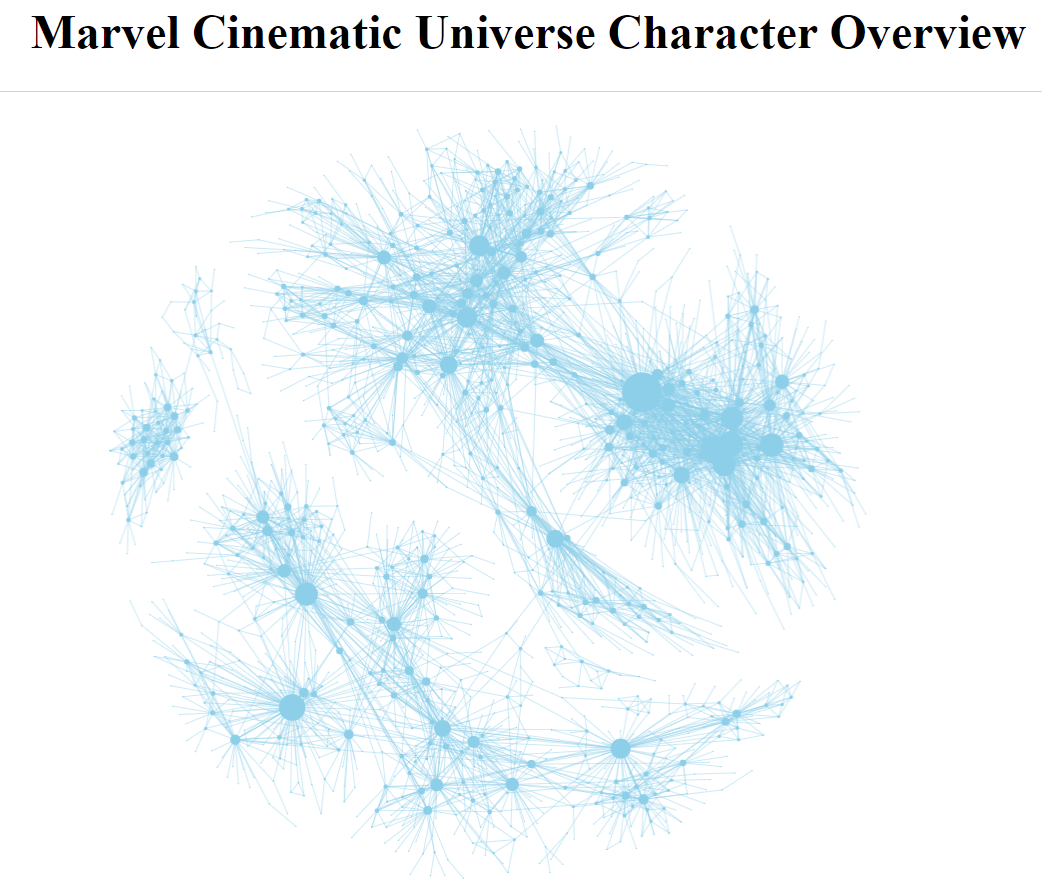

The complexity of the MCU is indeed illustrated through the network displayed above where many nodes are linked across the network. The network shows some interesting clusters and when hovering over some of the names in the small clusters, it can be assessed that many of the characters belong to the same tv-series or movie. When observing the large clusters, however, it is difficult to identify any clear connections between the characters. The network illuminates the characters with the largest number of connections which is Phil Coulson according to the node size. Furthermore, it is observed that the majority of the characters have a low number of connections (more information about this can be found in the explainer notebook).

**Visualise graph colored by teams**

In [22]:
# Colored by teams
nx.set_node_attributes(U_GCC,color_teams) # Changing node attribute
pyvis_graph(U_GCC, 'Marvel Cinematic Universe Character Overview, colored by status', 'output_from_explainer_notebook/character_graph_color_teams.html')
IFrame(src='https://drive.google.com/file/d/1dvbgaUBgq5apMT75pSp_F1Upk_xut_U7/view?usp=sharing', width=700, height=600)



This is the MCU network colored by teams. As a character can be a member of different teams, the node color is defined through the first team a character is mentioned in. The network shows some interesting patterns when looking at the big teams such as The Avengers (red), and Coulson's Team (orange) which are gathered in the same area although overlapping with some characters from other teams. It can be seen that Luke Cage and Jessica Jones are both part of the Defenders team thus connecting the two characters (and tv-series).

### MCU network graph with additional movie and tv-series as nodes
The network in the following section is the same graph as the MCU network but with additional nodes for the movies and tv-series. The links are created if a character appears in a movie or a tv-series. 
This is done in order to understand the connections between characters and movies, and to investigate if there are any patterns that sepearate the character in the MCU. 

First a copy of the graph is made and the nodes from the dataframes df_movies and df_tv is added to the graph. 

In [58]:
#Copy graph and create a graph with movies and characters as nodes
U_GCC_with_movies_tv_series = U_GCC.copy()
U_GCC_with_movies_tv_series.add_nodes_from(df_movies['movies'])
U_GCC_with_movies_tv_series.add_nodes_from(df_tv['tv_series'])

Next the links are established between character and movie/tv-series. This is done by looping over the attributes that contains information about what movie and tv-serie a character appears in. 

In [24]:
# Create links so we can see what character connects the movies and tv-series
tv_movie_character_links = {}

for k,v in attributes.items():
    links = []
    for va in v['tv-serie']:
        links.append(va)
    for vaa in v['movies']:
        links.append(vaa)
    tv_movie_character_links[k] = links

Create edge between movies and characters and tv-series and characters

In [25]:
# add edge between movies and character
for k, m in tv_movie_character_links.items():
    for i in m:
        U_GCC_with_movies_tv_series.add_edge(k,i)

Add attributes to the nodes. If the node is a movie or a tv-serie then the node shape is a diamond and the color for the movies depend on the phases and the colors of the tv-series are colored light green. 

In [26]:
# add atributes for movies and size and color
attribute_size = {}
for node in U_GCC_with_movies_tv_series.nodes():
    if (node in list(df_movies['movies'])):
        #set the node name as the key and the label as its value 
        attribute_size[node] = {'physics': False,'size': 20,'shape': 'diamond','title': node,'color': ''.join(df_movies[df_movies['movies'] == node]['color'].values)}
    elif (node in list(df_tv['tv_series'])):
        attribute_size[node] = {'physics': False,'size': 20, 'color': 'lightgreen','title': node, 'shape': 'diamond'}
    else: 
        attribute_size[node] = {'size': 20, 'color': 'skyblue'}

nx.set_node_attributes(U_GCC_with_movies_tv_series,attribute_size)
degrees = dict(U_GCC_with_movies_tv_series.degree)
degrees.update((key,value) for key, value in degrees.items())
nx.set_node_attributes(U_GCC_with_movies_tv_series,degrees,'size')

Visualise graph using pyvis

In [31]:
# Create graph with all characters and movies as nodes!
pyvis_graph(U_GCC_with_movies_tv_series, 'Marvel Cinematic Universe Character Overview with Movies and TV-series', 
            'output_from_explainer_notebook/mcu_character_graph_with_shows.html', gravity=-30, spring_length=100, 
            spring_strength=0.1, damping=1)

In [27]:
IFrame(src='output_from_explainer_notebook/mcu_character_graph_with_shows.html', width=700, height=600)



The network shows a central part with a lot of interconnections between characters and movies from the infinity saga which could indicate that storylines within these are highly dependent on each other. When looking at the remaining network, within the clusters floating away from the central part, we can see that these are all connected to a tv-series. In addition to this, most of the characters within these are only part of the tv-serie universe and do not appear in any of the movies. As an example it can be seen that tv-series such as Daredevil, Jessica Jones and Luke cage , have their own connected network. Other tv-series such as ‘Wanda Vision’ and ‘Loki’ link to the central part of the network and thus the characters also appear in the infinity saga.

## Movie and tv-serie graphs with main characters  <a name="Network_vis_movie_tv"></a> 
Next graphs are visualised in order to create an overview of the movies and tv-series within the MCU network. 
The first graph focusses on the movies and main characters. This graph is created in order illustrate how the movies are related to each other and to understand what movies you could potentially watch independently and which movies that could be related in a sense that they should be watched dependently in order to understand the plot.

Extract main characters and create a dictionary with the attributes for these

In [29]:
# Extract main characters from the movies and create a d dict with the movies 
# they have appeared in based on the attributes from the graph. 
main_characters = ('Iron Man', 'Spider-Man', 'Thor','Black Widow',
                   'Captain America', 'Captain Marvel','Doctor Strange', 'Hulk', 'Shang-Chi',
                   'Star-Lord','Hawkeye', 'Black Panther', 'Steve Rogers','Thena', 'Phil Coulson', 'Loki',
                  'Scarlet Witch', 'Vision', 'Winter Soldier')
# main_character_dict = {k: attributes.get(k, None) for k in main_characters}

movie_dict = {k: attributes.get(k, None) for k in main_characters}

Add attributes to the main characters and creat links between characters and movies. A link exisits between a character and a movie if the main character appears in the movie. 

In [30]:
# Add dict attributes for the main characters
dict_movies_attributes = {}
for k in list(main_characters):
    dict_movies_attributes[k] = {'Phase': 'character', 'color': 'skyblue', 'size': 10, 'title': k}

# Create links so we can see what character connects the movies
movie_links = {}
for k,v in movie_dict.items():
    movie_links[k] = [va for va in v['movies']]

In [31]:
G_movies_main_characters, GCC_movies_main_characters = \
                    create_graph(movie_links,dict_movies_attributes)

Number of nodes in total graph: 45
Number of edges in total graph: 96
Number of nodes in GCC: 41
Number of edges in GCC: 94


In [32]:
attribute = {}
for show in G_movies_main_characters.nodes():
    if show in list(df_movies['movies'].values):
        attribute[show] = { 'size': 12, 'shape': 'box'
                           ,'title': show, 'color': ''.join(df_movies[df_movies['movies'] == show]['color'].values)}
    else:
        attribute[show] = {'name': show, 'color': 'skyblue', 'size': 12, 'title': show}

nx.set_node_attributes(G_movies_main_characters, attribute)


Create graph

In [33]:
# Set attributes
nt = Network(height='750px', width='90%', 
             notebook = True, 
             heading='Marvel Cinematic Universe Movie Overview With Main Characters')

nt.from_nx(G_movies_main_characters.to_undirected())
nt.force_atlas_2based(gravity=-50, central_gravity=0.01, spring_length=50, spring_strength=0.02, damping=1, overlap=0)

neighbor_map = nt.get_adj_list()

# add neighbor data to node hover data
for node in nt.nodes:
    node['title'] += ' Neighbors:<br>' + '<br>'.join(neighbor_map[node['id']])
    node['value'] = len(neighbor_map[node['id']])

#nt.show('output_from_explainer_notebook/movie_graph_with_main_char_only.html')
IFrame(src='output_from_explainer_notebook/movie_graph_with_main_char_only.html', width=700, height=600)




The movie network shows many links between the movies and the main characters. As the node size indicates the nodes degree, it can be seen that Iron Man, Thor and Black Widow are the characters appearing in most movies. In the center of the graph the four avenger movies are places, connected to almost every character. This makes sense as it is mainly in these movies the characters are gathered trying to save the world from catastrophes. 


It can be seen that the 2 new movies; “Eternals” and “Shang Chi and The Legend of the Ten Rings” are outliers with no links to other movies. Therefore it is also assumed that if you watch Eternals, you do not need to have seen Iron Man, Captain America, Avengers etc. which can be refreshing for a new marvel fan. This is also explained by the end of the infinity saga, and marvels attempt to create a new world with new main characters and probably the start of phase 5 with a new crossover narrative(https://screenrant.com/marvel-phase-4-plan-infinity-saga-comparison-mcu/). It is expected that these two movies will become just as connected as the other movies in the coming years as new movies arrive. 


### Tv-series graph with main characters
Next graph is a movie graph overview with main characters and tv-series. This graph is created in order illustrate how the tv-series are related to each other.

Extract main characters of tv-series

In [34]:
main_characters_tv_serie = ['Nick Fury', 'Iron Fist', 'Jessica Jones', 'Phil Coulson', 'Peggy Carter', 'Thena', 'Spider-Man'
                  , 'Punisher', 'Daredevil', 'Luke Cage', 'Loki', 'Hawkeye', 'Scarlet Witch', 'Vision', 'Winter Soldier']


tv_dict = {k: attributes.get(k, None) for k in main_characters_tv_serie}

Add attributes 

In [35]:
# Add dict attributes for the main characters
dict_tv_attributes = {}
for k in list(main_characters_tv_serie):
    dict_tv_attributes[k] = {'Phase': 'character', 'color': 'blue', 'size': 10, 'title': k}

for k,v in dict_tv_attributes.items():
        dict_tv_attributes[k]['color'] = 'skyblue'

Create links to the tv-series, the links are connected in the same way as for the movie. 

In [37]:
# Create links so we can see what character connects the movies
tv_links = {}
for k,v in tv_dict.items():
    tv_links[k] = [va for va in v['tv-serie']]

Create graph

In [38]:
G_tv_main_characters, GCC_tv_main_characters = \
                    create_graph(tv_links, dict_tv_attributes)

Number of nodes in total graph: 34
Number of edges in total graph: 55
Number of nodes in GCC: 17
Number of edges in GCC: 27


Define colors for tv-series that has a connection to the infinity saga or are spinoffs of the saga. 

In [39]:
tv_series_phase_4 = ['Agent Carter (TV series)', 'Hawkeye (TV series)', 'Loki (TV series)','The Falcon and The Winter Soldier','WandaVision',
'What If...?','Spider-Man: Freshman Year']

In [43]:
tv_series_unique = list(df_tv['tv_series'])

In [45]:
attribute = {}
for show in G_tv_main_characters.nodes():
    if show in tv_series_unique:
        attribute[show] = {'color': 'lightgreen', 'size': 12, 'shape': 'box','title': show}
    if show in tv_series_phase_4:
        attribute[show] = {'color': 'magenta', 'size': 12, 'shape': 'box', 'title': show}


nx.set_node_attributes(G_tv_main_characters, attribute)

In [46]:
# Set attributes
nt = Network(height='750px', width='90%', 
             notebook = True, 
             heading='Marvel Cinematic Universe Tv-series Overview With Main Characters')

nt.from_nx(G_tv_main_characters.to_undirected())
nt.force_atlas_2based(gravity=-50, central_gravity=0.01, spring_length=50, spring_strength=0.02, damping=1, overlap=0)
neighbor_map = nt.get_adj_list()

# add neighbor data to node hover data
for node in nt.nodes:
    node['title'] += ' Neighbors:<br>' + '<br>'.join(neighbor_map[node['id']])
    node['value'] = len(neighbor_map[node['id']])

# nt.show('output_from_explainer_notebook/tv-series_graph_with_main_char_only.html')
IFrame(src='output_from_explainer_notebook/tv-series_graph_with_main_char_only', width=700, height=600)




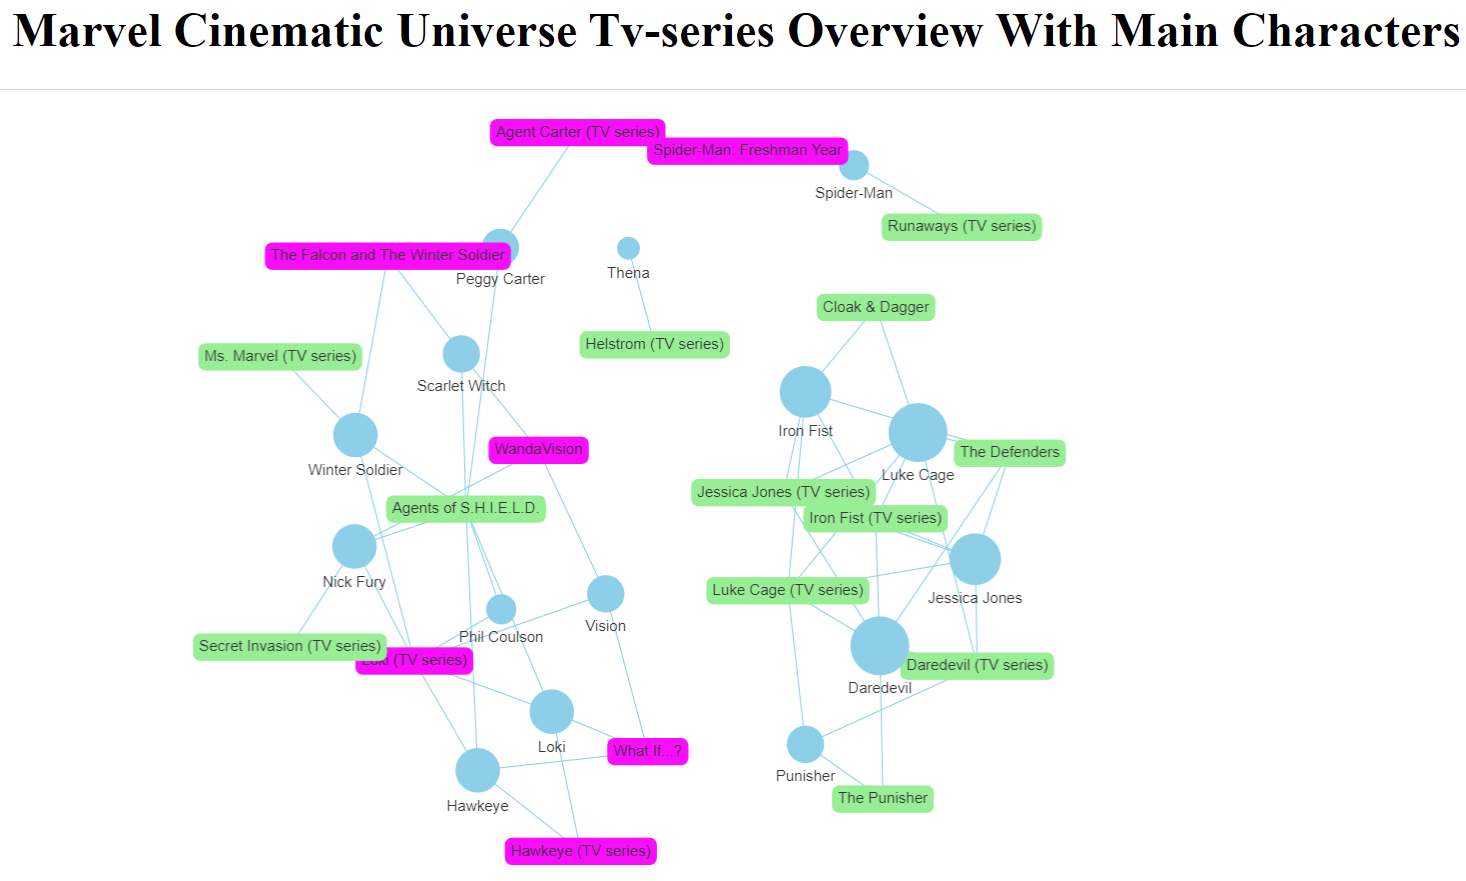


The first noticeable feature is that the network has 2 big clusters. The largest cluster contains many of the main characters from the movies e.g. Nick Fury, Phil Coulson, Hawkeye, Vision etc. together with the tv-series that are connected to the movies (reference til store network graph). 

The other cluster indicates that Marvel has created another universe not directly related with the events from the infinity saga through the tv-series such as Daredevil, Jessica Jones, Luke Cage. This means that one can watch these tv-series, without having to watch movies from the infinity saga in order to understand the plot. However it may happen that a tv-series character from Jessica Jones appears in an episode in Luke Cage tv-serie. 



## Organisation network graph  <a name="Network_vis_organisation"></a>

Next an organisation graph is created in order to get an overview of all the organisations within MCU and to determine the most important ones for the storyline.

The following functions are used to create the graph and add attributes to the graph. 

In [47]:
def org_team_att(dictionary):
    attributes_org = {}

    from random import randint
    colors = []
    n = len(dictionary)
    for i in range(n):
        
        colors.append('#%06X' % randint(0, 0xFFFFFF))
    n=0
    for keys, values in dictionary.items(): 
        attributes_org[keys] = {"Name": keys , "color": str(colors[n]), "shape": "diamond"}
        n = n+1
    return attributes_org

In [48]:
def get_edge_att(G, no_links_dict):
    '''
    Function that returns edge attributes
    '''
    edge_att ={}
    for u,v,_ in list(G.edges(data = True)):
        no_links = no_links_dict[u][v]
        edge_att[(u,v)]={'value': no_links, 'title': 'No. of shared characters:' + str(no_links)}
    return edge_att

Next the graph is create using the data loaded from the web scrabing

In [49]:
G_org, GCC_org = create_graph(org_characters, attributes_org)
nx.set_node_attributes(G_org, org_team_att(org_characters))

Number of nodes in total graph: 1397
Number of edges in total graph: 1424
Number of nodes in GCC: 966
Number of edges in GCC: 1108


In [51]:
pyvis_graph(G_org, "Marvel Organisations", 'output_from_explainer_notebook/org_graph5.html')
IFrame(src='output_from_explainer_notebook/org_graph5', width=700, height=600)

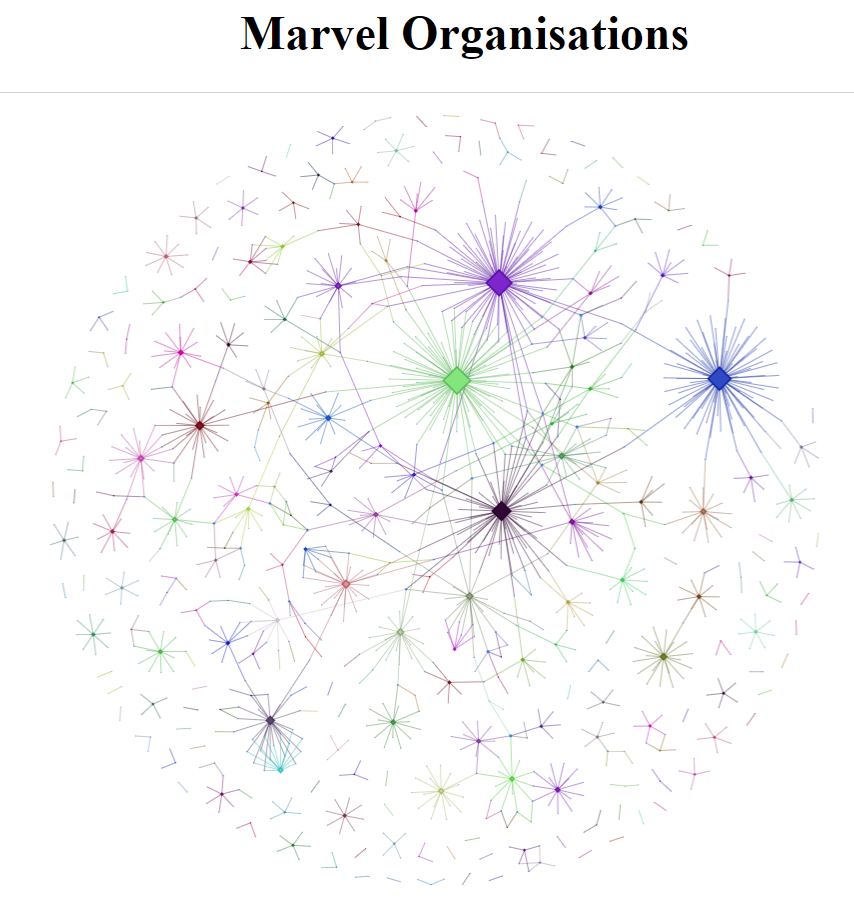

The network visualises all the organisations in MCU and the characters within each organisation. In the central part of the network the biggest organisations can be identified and when hovering other the nodes they are observed to be; S.H.I.E.L.D., HYDRA, United States Armed Forces and New York City Police Department. This makes good sense as S.H.I.E.L.D. and HYDRA are the two main counterparties within MCU. Characters involved in several organisations can either be a sign of alliance or deception. S.H.I.E.L.D. became a defunct agency due to HYDRA infiltration and when zooming in on the characters connecting HYDRA and SHIELD these undercover agents can be revealed. There are many small organisations which are more divided and do not share characters with other organisations. These could represent organisations only present in tv-series with no direct connection to the orginations originated from the infinity saga.


### Organisation graph with shared characters
Next a graph with organisations linking to other organisations if they share common characters is created, in order to get a better overview of how many characters there are part of several organisations. 

The graph is created below

In [52]:
G_org_org, GCC_org_org = create_graph(org_shared, org_team_att(org_shared))
nx.set_edge_attributes(G_org_org, get_edge_att(G_org_org, links_no))

Number of nodes in total graph: 155
Number of edges in total graph: 255
Number of nodes in GCC: 130
Number of edges in GCC: 237


Add attributes

In [53]:
titles = {}
for name, data in G_org_org.nodes(data = True):
    title = 'Organisation: '+ name +'</br>No. of shared characters: ' + str(data['size'])
    titles[name] = title

attribute = {}
for show in G_org_org.nodes():
    if show in list(org_shared.keys()):
        attribute[show] = {'shape': 'diamond'}
    else:
        attribute[show] = {'shape': 'diamond', 'color': 'purple'}

nx.set_node_attributes(G_org_org, titles, 'title')
nx.set_node_attributes(G_org_org, attribute)

In [180]:
pyvis_graph(G_org_org, "Organisations With Shared Characters", "./output_from_explainer_notebook/org_org_graph5.html", notebook=True)

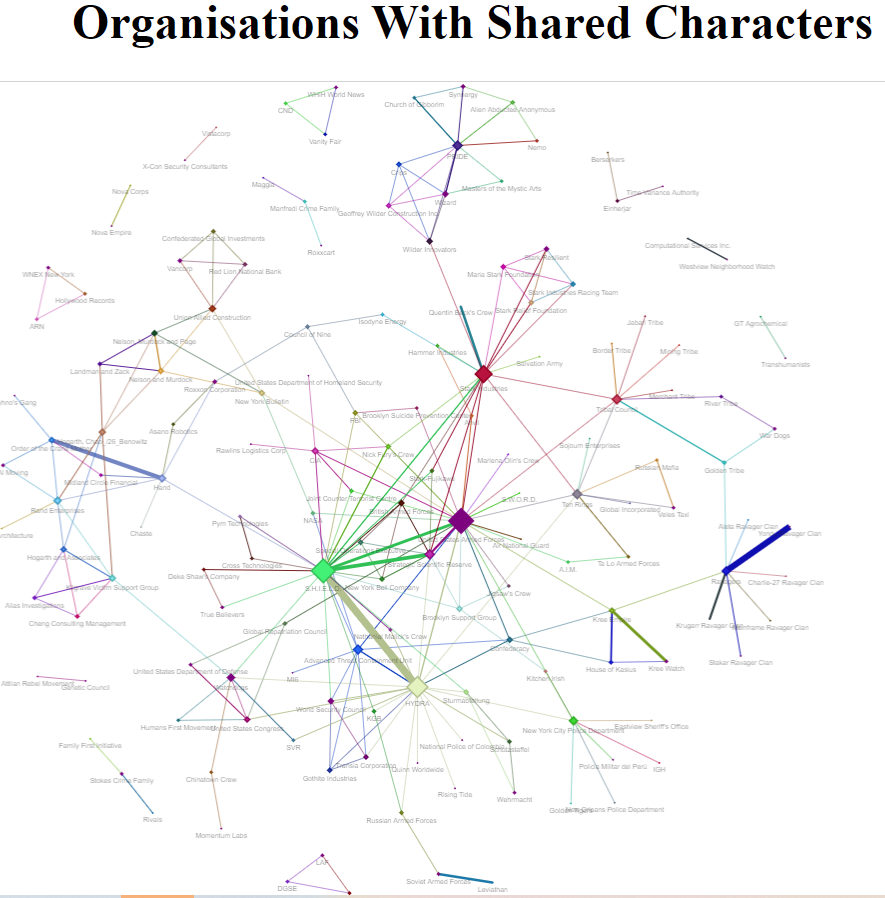

The edge size between two organisations are adjusted according to the number of shared characters between the two organisations. When hovering over the nodes in the network it is seen that the United States Armed Forces is the organisation that shares most characters with other organisations and that the largest number are with S.H.I.E.L.D. When observing the edge sizes it is seen that the two teams that share most characters are HYDRA  and S.H.I.E.L.D which is not surprising due to the HYDRA infiltration mentioned earlier. 

## Team network graph  <a name="Network_vis_team"></a>

Next a team graph is created in order to get an overview of all the teams within MCU and to determine the most important ones for the storyline.

In [55]:
def team_att(dictionary):
    attributes_team = {}
    
    from random import randint
    colors = []
    n = len(dictionary)
    for i in range(n):
        
        colors.append('#%06X' % randint(0, 0xFFFFFF))
    n=0
    for keys, values in dictionary.items(): 
        attributes_team[keys] = {"Name": keys , "color": str(colors[n]), "shape": "diamond"}
        n = n+1
    return attributes_team

Define the team graph

In [56]:
G_team, GCC_team = create_graph(team_characters,org_team_att(team_characters))
nx.set_node_attributes(G_team, attributes_teams)

Number of nodes in total graph: 338
Number of edges in total graph: 332
Number of nodes in GCC: 162
Number of edges in GCC: 184


Add attributes

In [57]:
titles = {}
c = 0
for name, data in G_team.nodes(data = True):
    if c >= 54:
        try:
            title = 'Name: '+ name +'</br>Team(s): ' + str(data['Team(s)']) + ' </br>Founder: ' + str(data['Founder']) + ' </br>Leader: ' + str(data['Leader']) + ' </br>Former leader: ' + str(data['Former leader'])+ ' </br>Member: ' + str(data['Member']) + ' </br>Former member: ' + str(data['Former member'])
        except:
            ""
    else:
        title = 'Team: '+ name +'</br>No. of members: ' + str(data['size'])
    titles[name] = title
    c = c+1
nx.set_node_attributes(G_team, titles, 'title')

Visualise graph using pyvis

In [178]:
pyvis_graph(G_team, "Marvel Teams", './output_from_explainer_notebook/team_graph5.html', notebook=True)

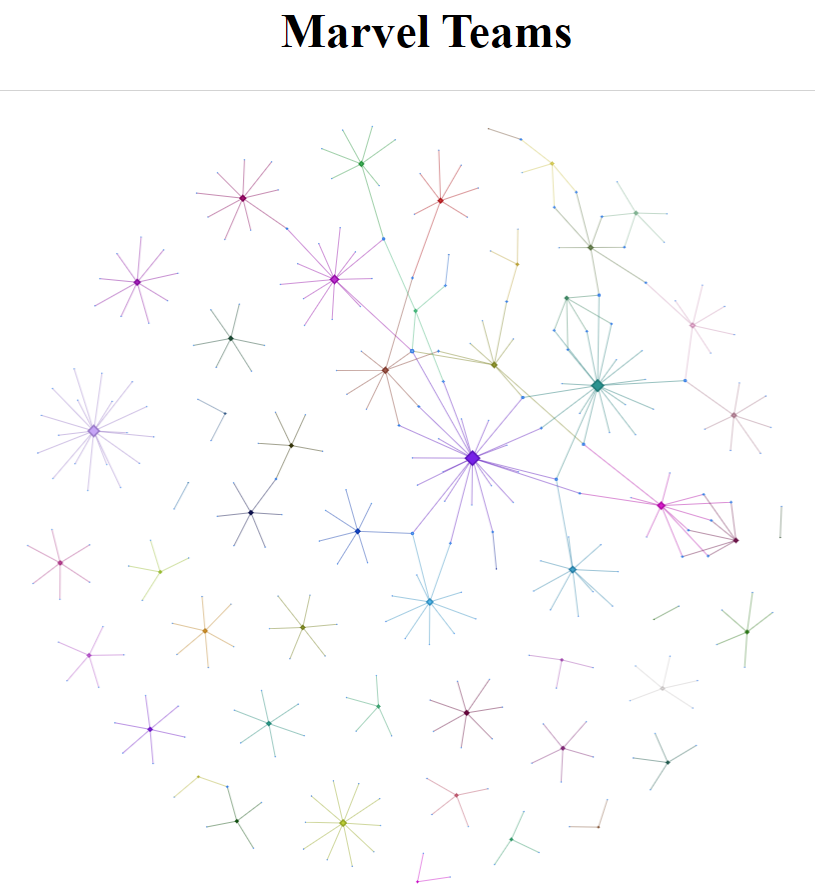

From the network it is seen that some characters are involved in several teams, connecting the nodes from one team to another. Especially when zooming in on Avengers (purple) and STRIKE (green) it is seen that the characters are connected to more than one team. When observing the node size it can be assessed that these are also the biggest teams within the network. This makes good sense as Avengers and STRIKE are central, counter-terrorist teams that recur in many of the movies and all of the phases. A character’s involvement in more than one team can either be a sign of alliance or deception if the character is an undercover agent. As Avengers and STRIKE both are units within the same organisation “SHIELD” it makes good sense that the teams are connected and the shared characters are most likely alliances. 
Most of the teams floating away from the central part of the network are more divided and do not share characters with other teams. These could represent the teams only present in tv-series with no direct connection to the teams originated from the infinity saga, such as Runaways, The Defenders and Fiona’s Crew. This is elaborated in the tv-series network in the dropdown menu.


### Teams graph with shared characters
Next a graph with teams linking to other teams is created in order to investigate how many characters each teams have in common, and to see how teams are related to each other. 

In [59]:
G_team_team, GCC_team_team = create_graph(team_shared,org_team_att(team_shared))
nx.set_edge_attributes(G_team_team, get_edge_att(G_team_team, links_no_team))

Number of nodes in total graph: 28
Number of edges in total graph: 40
Number of nodes in GCC: 24
Number of edges in GCC: 38


In [60]:
titles = {}
att = {}
for name, data in G_team_team.nodes(data = True):
    title = 'Team: '+ name +'</br>No. of shared characters: ' + str(data['size'])
    titles[name] = title


attribute = {}
for show in G_team_team.nodes():
    if show in list(team_shared.keys()):
        attribute[show] = {'shape': 'diamond'}
    else:
        attribute[show] = {'shape': 'diamond', 'color': 'purple'}

# add node attributes
nx.set_node_attributes(G_team_team, titles, 'title')
nx.set_node_attributes(G_team_team, attribute)

In [179]:
pyvis_graph(G_team_team, "Teams With Shared Characters", './output_from_explainer_notebook/team_team_graph4.html', notebook=True)

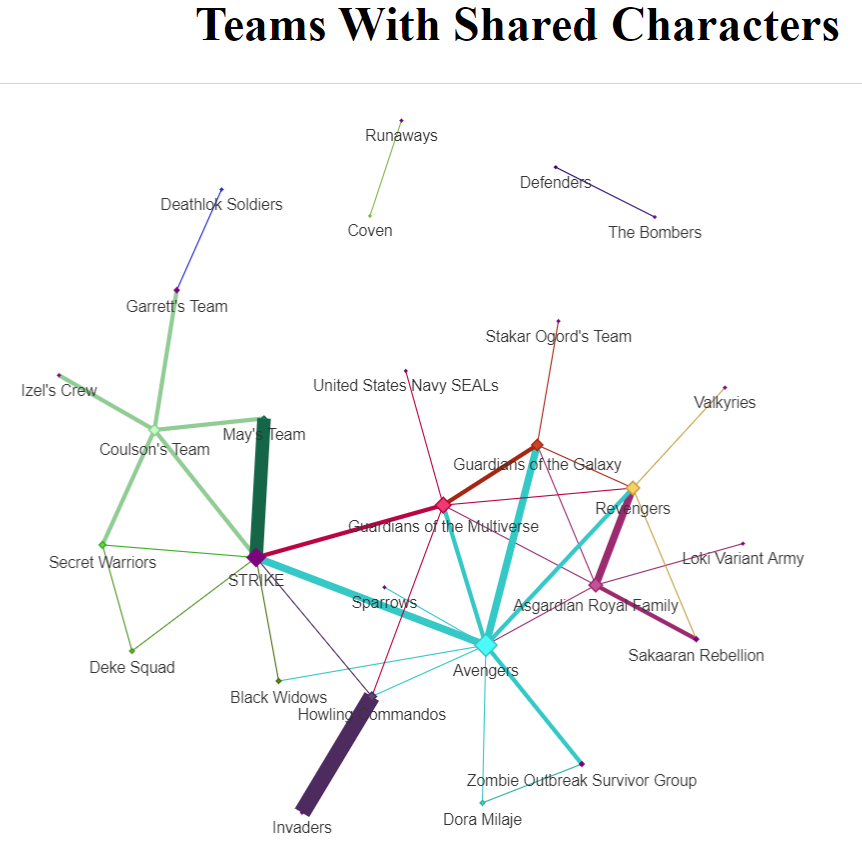

The edge size between two teams are adjusted according to the number of shared characters between the teams . When hovering over the nodes in the network it is seen that Avengers is the team that shares most characters with other teams.  When observing the edge sizes it is seen that the two teams that share most characters are “Howling Commandos” and “Invaders”.  